In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1aJsbt04Jz9xcLP_lg7fvP4Bpdce6GQlC/Pytorch-Models


In [ ]:
!pip uninstall onnxruntime -y
!pip install onnxruntime-gpu

In [ ]:
import onnxruntime
import numpy as np
import cv2
import torch

img_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (4).jpg"
# "mmpose/datasets/vitpose_models/giraffe-zebra.jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (550, 550))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("mit-onnx-models/yolact_550x550_opt.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

print("Output:", [o.shape for o in outputs])

input_shape = session.get_inputs()[0].shape
output_mask = session.get_outputs()[1]
mask_shape = np.asarray([output_mask.shape[1]]+[output_mask.shape[2]]+[3], dtype=np.int32)
print(mask_shape)

Output: [(1, 19248, 4), (1, 19248, 81), (1, 19248, 32), (19248, 4), (1, 138, 138, 32)]
[19248    81     3]


In [ ]:
COCO_CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                'scissors', 'teddy bear', 'hair drier', 'toothbrush')

def get_colors(num):
    colors = [[0, 0, 0]]
    np.random.seed(0)
    for i in range(num):
        color = np.random.randint(0, 256, [3]).astype(np.uint8)
        colors.append(color.tolist())
    return colors

# Prepare color table
colors = get_colors(len(COCO_CLASSES))

import numpy as np
import cv2

# Unpack ONNX outputs
loc = outputs[0][0]        # (N, 4) box deltas
conf = outputs[1][0]       # (N, 81) class scores (with background)
coeff = outputs[2][0]      # (N, 32) mask coefficients
priors = outputs[3]        # (N, 4) prior boxes (cx, cy, w, h) normalized to [0,1]
proto  = outputs[4][0]     # (138, 138, 32) prototype masks

H, W = img_resized.shape[:2]
conf_threshold = 0.1
mask_threshold = 0.3
variances = (0.1, 0.2)

# 1) Decode boxes (SSD-style)
def decode(loc, priors, variances, W, H):
    cx = priors[:, 0]; cy = priors[:, 1]
    pw = priors[:, 2]; ph = priors[:, 3]

    dcx = cx + loc[:, 0] * variances[0] * pw
    dcy = cy + loc[:, 1] * variances[0] * ph
    dw  = pw * np.exp(loc[:, 2] * variances[1])
    dh  = ph * np.exp(loc[:, 3] * variances[1])

    x1 = (dcx - dw / 2) * W
    y1 = (dcy - dh / 2) * H
    x2 = (dcx + dw / 2) * W
    y2 = (dcy + dh / 2) * H
    return np.stack([x1, y1, x2, y2], axis=1)

boxes_decoded = decode(loc, priors, variances, W, H)  # (N, 4)

# 2) Class scores (drop background at [:,0])
scores_no_bg = conf[:, 1:]                      # (N, 80)
class_ids = np.argmax(scores_no_bg, axis=1)     # 0..79 (COCO)
confs = scores_no_bg[np.arange(scores_no_bg.shape[0]), class_ids]

keep = confs > conf_threshold
boxes_decoded = boxes_decoded[keep]
class_ids = class_ids[keep]
confs = confs[keep]
coeff = coeff[keep]

# 3) (Optional) simple NMS per-class to reduce duplicates
def nms(boxes, scores, iou_thresh=0.4, top_k=200):
    if boxes.size == 0: return np.array([], dtype=np.int32)
    x1, y1, x2, y2 = boxes.T
    areas = (x2 - x1).clip(0) * (y2 - y1).clip(0)
    order = scores.argsort()[::-1]
    keep_idx = []
    while order.size > 0 and len(keep_idx) < top_k:
        i = order[0]
        keep_idx.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = (xx2 - xx1).clip(0)
        h = (yy2 - yy1).clip(0)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
        order = order[1:][iou <= iou_thresh]
    return np.array(keep_idx, dtype=np.int32)

final_boxes, final_classes, final_scores, final_coeffs = [], [], [], []
for c in np.unique(class_ids):
    idxs = np.where(class_ids == c)[0]
    if idxs.size == 0: continue
    keep_idx = nms(boxes_decoded[idxs], confs[idxs], iou_thresh=0.4, top_k=100)
    if keep_idx.size == 0: continue
    final_boxes.append(boxes_decoded[idxs][keep_idx])
    final_classes.append(class_ids[idxs][keep_idx])
    final_scores.append(confs[idxs][keep_idx])
    final_coeffs.append(coeff[idxs][keep_idx])

if len(final_boxes) == 0:
    bboxes = []; classes = []; confs_out = []; masks = []
else:
    bboxes = np.concatenate(final_boxes, axis=0)
    classes = np.concatenate(final_classes, axis=0)
    confs_out = np.concatenate(final_scores, axis=0)
    coeffs_out = np.concatenate(final_coeffs, axis=0)

    # 4) Build instance masks from prototypes
    proto_h, proto_w, proto_d = proto.shape  # 138, 138, 32
    proto2 = proto.reshape(-1, proto_d)      # (H*W, 32)

    masks = []
    for i in range(coeffs_out.shape[0]):
        m = proto2 @ coeffs_out[i]           # (H*W,)
        m = m.reshape(proto_h, proto_w)
        m = 1.0 / (1.0 + np.exp(-m))         # sigmoid
        # upsample to network image size
        m_up = cv2.resize(m, (W, H), interpolation=cv2.INTER_LINEAR)
        # crop to its bbox
        x1, y1, x2, y2 = bboxes[i].astype(int)
        x1 = np.clip(x1, 0, W - 1); y1 = np.clip(y1, 0, H - 1)
        x2 = np.clip(x2, 0, W - 1); y2 = np.clip(y2, 0, H - 1)
        inst = np.zeros((H, W), dtype=np.uint8)
        if x2 > x1 and y2 > y1:
            inst[y1:y2, x1:x2] = (m_up[y1:y2, x1:x2] > mask_threshold).astype(np.uint8)
        masks.append(inst)

# Convert numpy arrays to lists if your later code expects lists
bboxes = [b.tolist() for b in bboxes] if len(bboxes) else []
classes = classes.tolist() if len(bboxes) else []
confs = confs_out.tolist() if len(bboxes) else []

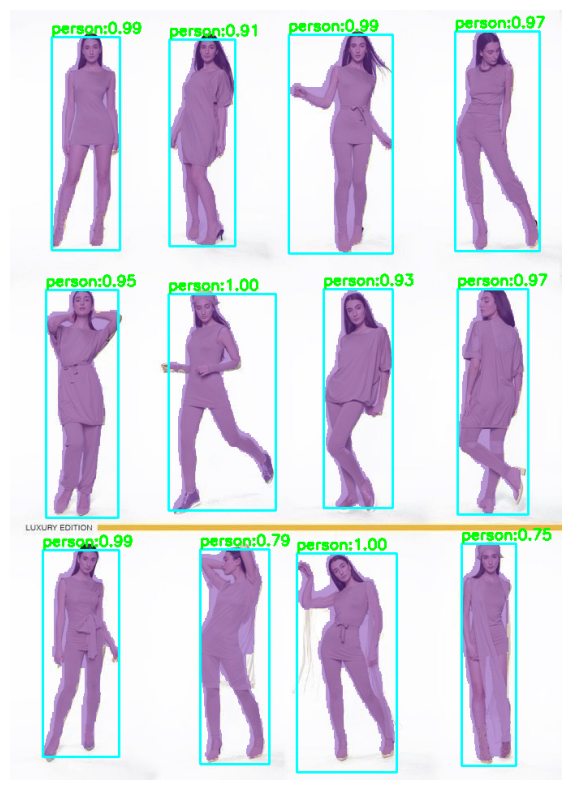

In [ ]:
import matplotlib.pyplot as plt

frame_height, frame_width = img.shape[:2]
net_h, net_w = img_resized.shape[:2]

# Scale bboxes back to original image size
scaled_bboxes = []
for bx in bboxes:
    x1 = int(bx[0] * frame_width / net_w)
    y1 = int(bx[1] * frame_height / net_h)
    x2 = int(bx[2] * frame_width / net_w)
    y2 = int(bx[3] * frame_height / net_h)
    scaled_bboxes.append([x1, y1, x2, y2])

# Resize masks to original size
scaled_masks = [
    cv2.resize(m, (frame_width, frame_height), interpolation=cv2.INTER_NEAREST)
    for m in masks
]

img_with_mask = img.copy()
alpha = 0.5  # transparency

for mask, class_id in zip(scaled_masks, classes):
    color = np.array(colors[class_id + 1], dtype=np.uint8)  # (3,)
    mask_bool = mask > 0

    # Apply alpha blend only on masked pixels
    img_with_mask[mask_bool] = (
        alpha * color + (1 - alpha) * img_with_mask[mask_bool]
    ).astype(np.uint8)

# Draw boxes + labels
for bbox, score, class_id in zip(scaled_bboxes, confs, classes):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img_with_mask, (x1, y1), (x2, y2), (255, 255, 0), 2)
    cv2.putText(img_with_mask,
                f'{COCO_CLASSES[class_id]}:{score:.2f}',
                (x1, max(y1 - 5, 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                (0, 255, 0), 2)

# Convert BGR → RGB for matplotlib
img_rgb = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

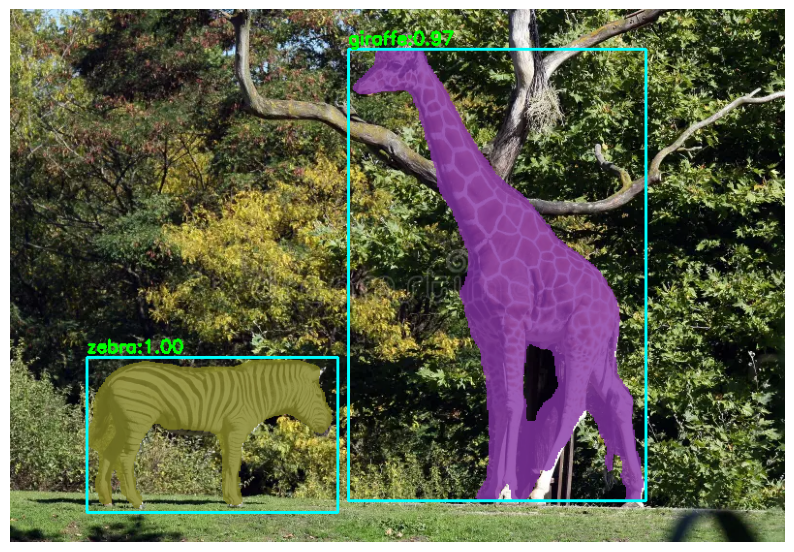

In [ ]:
import matplotlib.pyplot as plt

frame_height, frame_width = img.shape[:2]
net_h, net_w = img_resized.shape[:2]

# Scale bboxes back to original image size
scaled_bboxes = []
for bx in bboxes:
    x1 = int(bx[0] * frame_width / net_w)
    y1 = int(bx[1] * frame_height / net_h)
    x2 = int(bx[2] * frame_width / net_w)
    y2 = int(bx[3] * frame_height / net_h)
    scaled_bboxes.append([x1, y1, x2, y2])

# Resize masks to original size
scaled_masks = [
    cv2.resize(m, (frame_width, frame_height), interpolation=cv2.INTER_NEAREST)
    for m in masks
]

img_with_mask = img.copy()
alpha = 0.8  # transparency

for mask, class_id in zip(scaled_masks, classes):
    color = np.array(colors[class_id + 1], dtype=np.uint8)  # (3,)
    mask_bool = mask > 0

    # Apply alpha blend only on masked pixels
    img_with_mask[mask_bool] = (
        alpha * color + (1 - alpha) * img_with_mask[mask_bool]
    ).astype(np.uint8)

# Draw boxes + labels
for bbox, score, class_id in zip(scaled_bboxes, confs, classes):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img_with_mask, (x1, y1), (x2, y2), (255, 255, 0), 2)
    cv2.putText(img_with_mask,
                f'{COCO_CLASSES[class_id]}:{score:.2f}',
                (x1, max(y1 - 5, 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                (0, 255, 0), 2)

# Convert BGR → RGB for matplotlib
img_rgb = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [ ]:
import onnxruntime
import numpy as np
import cv2
import torch

img_path = "mmpose/datasets/vitpose_models/family.jpg"
# "mmpose/datasets/vitpose_models/giraffe-zebra.jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (1344, 768))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("mit-onnx-models/sparseinst_r50_giam_aug_768x1344_opt.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

print("Output:", [o.shape for o in outputs])

Output: [(100, 768, 1344), (100,), (100,)]


In [ ]:
# Post process
mask_preds = np.array(outputs[0])
scores = np.array(outputs[1])
labels = np.array(outputs[2])

conf_threshold = 0.5
nms_threshold = 0.5
min_area = 500  # filter tiny regions

# Extraction by score threshold
masks = mask_preds[scores > conf_threshold]
labels = labels[scores > conf_threshold]
scores = scores[scores > conf_threshold]

# Bounding Rectangle
bboxes = []
final_masks = []
final_scores = []
final_labels = []

frame_height, frame_width = img.shape[:2]

for mask, score, label in zip(masks, scores, labels):
    contours, _ = cv2.findContours((mask * 255).astype('uint8'),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < min_area:
            continue  # skip small noise
        x, y, w, h = cv2.boundingRect(contour)
        x = int((x / 1344) * frame_width)
        y = int((y / 768) * frame_height)
        w = int((w / 1344) * frame_width)
        h = int((h / 768) * frame_height)
        bboxes.append([x, y, x + w, y + h])
        final_masks.append(mask)
        final_scores.append(score)
        final_labels.append(label)

# Apply NMS
# NOTE: NMSBoxes requires [x, y, w, h] not [x1, y1, x2, y2]
boxes_xywh = []
for (x1, y1, x2, y2) in bboxes:
    boxes_xywh.append([x1, y1, x2 - x1, y2 - y1])

indices = cv2.dnn.NMSBoxes(
    boxes_xywh, final_scores, conf_threshold, nms_threshold
)

bboxes_list = []
masks_list = []
scores_list = []
labels_list = []

if len(indices) > 0:
    for idx in indices.flatten():  # flatten fixes nested [[i]]
        bboxes_list.append(bboxes[idx])       # keep original [x1, y1, x2, y2]
        masks_list.append(final_masks[idx])
        scores_list.append(final_scores[idx])
        labels_list.append(final_labels[idx])

def get_id_color(index):
    temp_index = abs(int(index + 1)) * 3
    color = ((37 * temp_index) % 255, (17 * temp_index) % 255,
             (29 * temp_index) % 255)
    return color

COCO_CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                'scissors', 'teddy bear', 'hair drier', 'toothbrush')

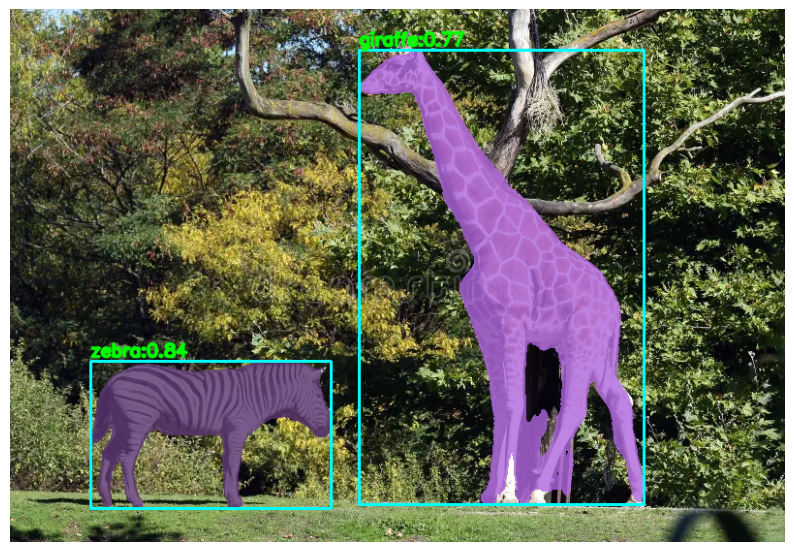

In [ ]:
import matplotlib.pyplot as plt

image_height, image_width = img.shape[:2]
img_with_mask = img.copy()

alpha = 0.8  # transparency

for index, (mask, score, label,
            bboxes) in enumerate(zip(masks_list, scores_list, labels_list, bboxes_list)):
    if score < conf_threshold:
        continue

    color = get_id_color(index)

    # Color image
    color_image = np.zeros(img.shape, dtype=np.uint8)
    color_image[:] = color

    # Resized mask image
    mask = np.stack((mask, ) * 3, axis=-1).astype('uint8')
    resize_mask = cv2.resize(mask, (image_width, image_height))

    # Mask addWeighted
    mask_image = np.where(resize_mask, color_image, img_with_mask)
    img_with_mask = cv2.addWeighted(img_with_mask, 1-alpha, mask_image, alpha, 1.0)

    # Bounding box & Label
    x1, y1, x2, y2 = map(int, bboxes)
    cv2.rectangle(img_with_mask, (x1, y1), (x2, y2), (255, 255, 0), 2)
    cv2.putText(img_with_mask, f'{COCO_CLASSES[label]}:{score:.2f}', (x1, max(y1 - 5, 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2,
                cv2.LINE_AA)

# Convert BGR → RGB for matplotlib
img_rgb = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

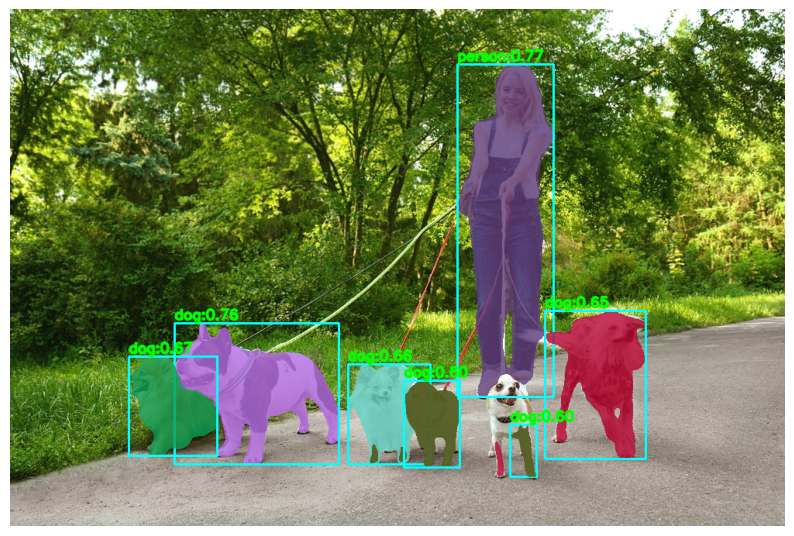

In [ ]:
import matplotlib.pyplot as plt

image_height, image_width = img.shape[:2]
img_with_mask = img.copy()

alpha = 0.8  # transparency

for index, (mask, score, label,
            bboxes) in enumerate(zip(masks_list, scores_list, labels_list, bboxes_list)):
    if score < conf_threshold:
        continue

    color = get_id_color(index)

    # Color image
    color_image = np.zeros(img.shape, dtype=np.uint8)
    color_image[:] = color

    # Resized mask image
    mask = np.stack((mask, ) * 3, axis=-1).astype('uint8')
    resize_mask = cv2.resize(mask, (image_width, image_height))

    # Mask addWeighted
    mask_image = np.where(resize_mask, color_image, img_with_mask)
    img_with_mask = cv2.addWeighted(img_with_mask, 1-alpha, mask_image, alpha, 1.0)

    # Bounding box & Label
    x1, y1, x2, y2 = map(int, bboxes)
    cv2.rectangle(img_with_mask, (x1, y1), (x2, y2), (255, 255, 0), 2)
    cv2.putText(img_with_mask, f'{COCO_CLASSES[label]}:{score:.2f}', (x1, max(y1 - 5, 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2,
                cv2.LINE_AA)

# Convert BGR → RGB for matplotlib
img_rgb = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [ ]:
import onnxruntime
import numpy as np
import cv2
import torch

img_path = "datasets/pose-tests/pose (7).jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (256, 256))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("mit-onnx-models/mobile_human_pose_working_well_256x256.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

print("Output:", [o.shape for o in outputs])

Output: [(1, 672, 32, 32)]


In [ ]:
import sys
import cv2
import numpy as np
import onnxruntime
from scipy.special import softmax
import matplotlib.pyplot as plt

joints_name = ('Head_top', 'Thorax', 'R_Shoulder', 'R_Elbow', 'R_Wrist', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'R_Hip', 'R_Knee', 'R_Ankle', 'L_Hip', 'L_Knee', 'L_Ankle', 'Pelvis', 'Spine', 'Head', 'R_Hand', 'L_Hand', 'R_Toe', 'L_Toe')
joint_num = len(joints_name) # 21
skeleton = ( (0, 16), (16, 1), (1, 15), (15, 14), (14, 8), (14, 11), (8, 9), (9, 10), (10, 19), (11, 12), (12, 13), (13, 20), (1, 2), (2, 3), (3, 4), (4, 17), (1, 5), (5, 6), (6, 7), (7, 18) )

cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, joint_num + 2)]
colors_cv = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]
colors_plt = [np.array((c[0], c[1], c[2])) for c in colors]

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(111, projection='3d')
plt.close(fig)

COCO_CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                'scissors', 'teddy bear', 'hair drier', 'toothbrush')

def get_colors(num):
    colors = [[0, 0, 0]]
    np.random.seed(0)
    for i in range(num):
        color = np.random.randint(0, 256, [3]).astype(np.uint8)
        colors.append(color.tolist())
    return colors

# Prepare color table
colors = get_colors(len(COCO_CLASSES))

def decode(loc, priors, variances, W, H):
    cx = priors[:, 0]; cy = priors[:, 1]
    pw = priors[:, 2]; ph = priors[:, 3]

    dcx = cx + loc[:, 0] * variances[0] * pw
    dcy = cy + loc[:, 1] * variances[0] * ph
    dw  = pw * np.exp(loc[:, 2] * variances[1])
    dh  = ph * np.exp(loc[:, 3] * variances[1])

    x1 = (dcx - dw / 2) * W
    y1 = (dcy - dh / 2) * H
    x2 = (dcx + dw / 2) * W
    y2 = (dcy + dh / 2) * H
    return np.stack([x1, y1, x2, y2], axis=1)

def nms(boxes, scores, iou_thresh=0.4, top_k=200):
    if boxes.size == 0: return np.array([], dtype=np.int32)
    x1, y1, x2, y2 = boxes.T
    areas = (x2 - x1).clip(0) * (y2 - y1).clip(0)
    order = scores.argsort()[::-1]
    keep_idx = []
    while order.size > 0 and len(keep_idx) < top_k:
        i = order[0]
        keep_idx.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = (xx2 - xx1).clip(0)
        h = (yy2 - yy1).clip(0)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
        order = order[1:][iou <= iou_thresh]
    return np.array(keep_idx, dtype=np.int32)

def crop_image(image, bbox):

    xmin = int(bbox[0])
    ymin = int(bbox[1])
    xmax = int(bbox[2])
    ymax = int(bbox[3])

    input_image = image[ymin:ymax,xmin:xmax]

    return input_image

def pixel2cam(pixel_coord, depth, f, c):

    # TODO: Fix deprojection of 2D joints
    # x = (pixel_coord[:, 0] - c[0]) / f[0] * depth
    # y = (pixel_coord[:, 1] - c[1]) / f[1] * depth
    # z = depth
    # cam_coord = np.concatenate((x[:,None], y[:,None], z[:,None]),1)
    cam_coord = np.concatenate((pixel_coord[:, 0][:,None], pixel_coord[:, 1][:,None], depth[:,None]),1)
    return cam_coord

def draw_skeleton(img, keypoints, scores, kp_thres = 0.02):

    for i, segment in enumerate(skeleton):
        point1_id = segment[0]
        point2_id = segment[1]

        point1 = (int(keypoints[point1_id, 0]), int(keypoints[point1_id, 1]))
        point2 = (int(keypoints[point2_id, 0]), int(keypoints[point2_id, 1]))

        img = cv2.line(img, point1, point2,colors_cv[i], thickness=3, lineType=cv2.LINE_AA)
        cv2.circle(img, point1, radius=5, color=colors_cv[i], thickness=-1, lineType=cv2.LINE_AA)
        cv2.circle(img, point2, radius=5, color=colors_cv[i], thickness=-1, lineType=cv2.LINE_AA)

        ''' In case confidence is used
        if scores[point1_id] > kp_thres and scores[point2_id] > kp_thres:
            img = cv2.line(img, point1, point2,colors[i], thickness=3, lineType=cv2.LINE_AA)

        if scores[point1_id] > kp_thres:
            cv2.circle(img, point1, radius=5, color=colors[i], thickness=-1, lineType=cv2.LINE_AA)

        if scores[point2_id] > kp_thres:
            cv2.circle(img, point2, radius=5, color=colors[i], thickness=-1, lineType=cv2.LINE_AA)

        '''

    return img

def draw_heatmap(img, img_heatmap):

    norm_heatmap = (255*((img_heatmap-np.min(img_heatmap))/(np.max(img_heatmap) - np.min(img_heatmap))))
    color_heatmap = cv2.applyColorMap(cv2.convertScaleAbs(norm_heatmap,1), cv2.COLORMAP_MAGMA)
    return cv2.addWeighted(img, 0.4, color_heatmap, 0.6, 0)

def vis_3d_multiple_skeleton(kpt_3d, kpt_3d_vis, filename=None):
    ax.cla()
    for l in range(len(skeleton)):
        i1 = skeleton[l][0]
        i2 = skeleton[l][1]

        person_num = kpt_3d.shape[0]
        for n in range(person_num):
            x = np.array([kpt_3d[n,i1,0], kpt_3d[n,i2,0]])
            y = np.array([kpt_3d[n,i1,1], kpt_3d[n,i2,1]])
            z = np.array([kpt_3d[n,i1,2], kpt_3d[n,i2,2]])

            if kpt_3d_vis[n,i1,0] > 0 and kpt_3d_vis[n,i2,0] > 0:
                ax.plot(x, z, -y, color=colors_plt[l], linewidth=4)
            if kpt_3d_vis[n,i1,0] > 0:
                ax.scatter(kpt_3d[n,i1,0], kpt_3d[n,i1,2], -kpt_3d[n,i1,1], color=colors_plt[l], marker='o', s=40)
            if kpt_3d_vis[n,i2,0] > 0:
                ax.scatter(kpt_3d[n,i2,0], kpt_3d[n,i2,2], -kpt_3d[n,i2,1], color=colors_plt[l], marker='o', s=40)
    #  Hide grid lines
    ax.xaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.fill = False
    ax.yaxis.pane.set_edgecolor('white')
    # ax.zaxis.pane.fill = False
    ax.zaxis.pane.set_edgecolor('white')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.view_init(elev=7, azim=-74)
    plt.tight_layout()

    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

    fig.canvas = FigureCanvas(fig)
    fig.canvas.draw()

    # Get RGBA buffer and convert to uint8 array
    img_3dpos = np.asarray(fig.canvas.renderer.buffer_rgba(), dtype=np.uint8)

    # Convert RGBA → BGR for OpenCV
    img_3dpos = cv2.cvtColor(img_3dpos, cv2.COLOR_RGBA2BGR)
    plt.close(fig)

    return img_3dpos

# --- MobileHumanPose class ---
class MobileHumanPose():
    def __init__(self, model_path, focal_length = [1500, 1500], principal_points = [1280/2, 720/2]):
        self.focal_length = focal_length
        self.principal_points = principal_points
        self.model = self.initialize_model(model_path)

    def __call__(self, image, bbox, abs_depth = 1.0):
        return self.estimate_pose(image, bbox, abs_depth)

    def initialize_model(self, model_path):
        self.session = onnxruntime.InferenceSession(model_path,
                                                    providers=['CPUExecutionProvider'])
        self.getModel_input_details()
        self.getModel_output_details()

    def estimate_pose(self, image, bbox, abs_depth = 1000):
        input_tensor = self.prepare_input(image, bbox)
        output = self.inference(input_tensor)
        keypoints = self.process_output(output, abs_depth, bbox)
        return keypoints

    def prepare_input(self, image, bbox):
        img = crop_image(image, bbox)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.img_height, self.img_width, self.img_channels = img.shape
        img_input = cv2.resize(img, (self.input_width,self.input_height))
        img_input = img_input.transpose(2, 0, 1)[np.newaxis,:,:,:]
        return img_input.astype(np.float32)

    def inference(self, input_tensor):
        output = self.session.run(self.output_names, {self.input_name: input_tensor})[0]
        return np.squeeze(output)

    def process_output(self, output, abs_depth, bbox):
        heatmaps = output.reshape((-1,self.joint_num, self.output_depth*self.output_height*self.output_width))
        heatmaps = softmax(heatmaps, 2)
        scores = np.squeeze(np.max(heatmaps, 2))
        heatmaps = heatmaps.reshape((-1, self.joint_num, self.output_depth, self.output_height, self.output_width))
        accu_x = heatmaps.sum(axis=(2,3))
        accu_y = heatmaps.sum(axis=(2,4))
        accu_z = heatmaps.sum(axis=(3,4))
        accu_x = accu_x * np.arange(self.output_width, dtype=np.float32)
        accu_y = accu_y * np.arange(self.output_height, dtype=np.float32)
        accu_z = accu_z * np.arange(self.output_depth, dtype=np.float32)
        accu_x = accu_x.sum(axis=2, keepdims=True)
        accu_y = accu_y.sum(axis=2, keepdims=True)
        accu_z = accu_z.sum(axis=2, keepdims=True)
        accu_x = accu_x/self.output_width
        accu_y = accu_y/self.output_height
        accu_z = accu_z/self.output_depth*2 - 1
        coord_out = np.squeeze(np.concatenate((accu_x, accu_y, accu_z), axis=2))
        pose_2d = coord_out[:,:2]
        pose_2d[:,0] = pose_2d[:,0] * self.img_width + bbox[0]
        pose_2d[:,1] = pose_2d[:,1] * self.img_height + bbox[1]
        joint_depth = coord_out[:,2]*1000 + abs_depth
        pose_3d = pixel2cam(pose_2d, joint_depth, self.focal_length, self.principal_points)
        person_heatmap = cv2.resize(np.sqrt(heatmaps.sum(axis=(1,2))[0,:,:]), (self.img_width,self.img_height))
        return pose_2d, pose_3d, person_heatmap, scores

    def getModel_input_details(self):
        self.input_name = self.session.get_inputs()[0].name
        self.input_shape = self.session.get_inputs()[0].shape
        self.channels = self.input_shape[1]
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]

    def getModel_output_details(self):
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[0].name]
        self.output_shape = model_outputs[0].shape  # e.g., (1, C, H, W)

        C, H, W = self.output_shape[1], self.output_shape[2], self.output_shape[3]

        # Automatically infer joint_num
        possible_joints = [17, 18, 21, 24, 32]  # common human pose joints
        for jn in possible_joints:
            if C % jn == 0:
                self.joint_num = jn
                self.output_depth = C // jn
                break
        else:
            # fallback
            self.joint_num = 21
            self.output_depth = C // 21

        self.output_height = H
        self.output_width = W

# --- Flexible detector function ---
# def detect_people(image):
#     """
#     Replace this with any detection model.
#     Must return boxes (N,4) and scores (N,)
#     Here: dummy single person covering the whole image for test
#     """
#     h, w = image.shape[:2]
#     boxes = np.array([[0,0,w,h]])
#     scores = np.array([1.0])
#     print(boxes)
#     return boxes, scores

def detect_people(image):
    img_resized = cv2.resize(image, (550, 550))
    img_input1 = img_resized.astype(np.float32) / 255.0
    img_input1 = img_input1.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

    session1 = onnxruntime.InferenceSession("mit-onnx-models/yolact_550x550_opt.onnx", providers=["CPUExecutionProvider"])
    input_name1 = session1.get_inputs()[0].name
    outputs = session1.run(None, {input_name1: img_input1})

    input_shape1 = session1.get_inputs()[0].shape
    output_mask1 = session1.get_outputs()[1]
    mask_shape = np.asarray([output_mask1.shape[1]]+[output_mask1.shape[2]]+[3], dtype=np.int32)

    # Unpack ONNX outputs
    loc = outputs[0][0]        # (N, 4) box deltas
    conf = outputs[1][0]       # (N, 81) class scores (with background)
    coeff = outputs[2][0]      # (N, 32) mask coefficients
    priors = outputs[3]        # (N, 4) prior boxes (cx, cy, w, h) normalized to [0,1]
    proto  = outputs[4][0]     # (138, 138, 32) prototype masks

    H, W = img_resized.shape[:2]
    conf_threshold = 0.1
    mask_threshold = 0.3
    variances = (0.1, 0.2)

    boxes_decoded = decode(loc, priors, variances, W, H)  # (N, 4)

    # 2) Class scores (drop background at [:,0])
    scores_no_bg = conf[:, 1:]                      # (N, 80)
    class_ids = np.argmax(scores_no_bg, axis=1)     # 0..79 (COCO)
    confs = scores_no_bg[np.arange(scores_no_bg.shape[0]), class_ids]

    keep = confs > conf_threshold
    boxes_decoded = boxes_decoded[keep]
    class_ids = class_ids[keep]
    confs = confs[keep]
    coeff = coeff[keep]

    final_boxes, final_classes, final_scores, final_coeffs = [], [], [], []
    for c in np.unique(class_ids):
        idxs = np.where(class_ids == c)[0]
        if idxs.size == 0: continue
        keep_idx = nms(boxes_decoded[idxs], confs[idxs], iou_thresh=0.4, top_k=100)
        if keep_idx.size == 0: continue
        final_boxes.append(boxes_decoded[idxs][keep_idx])
        final_classes.append(class_ids[idxs][keep_idx])
        final_scores.append(confs[idxs][keep_idx])
        final_coeffs.append(coeff[idxs][keep_idx])

    if len(final_boxes) == 0:
        bboxes = []; classes = []; confs_out = []; masks = []
    else:
        bboxes = np.concatenate(final_boxes, axis=0)
        classes = np.concatenate(final_classes, axis=0)
        confs_out = np.concatenate(final_scores, axis=0)
        coeffs_out = np.concatenate(final_coeffs, axis=0)

        # 4) Build instance masks from prototypes
        proto_h, proto_w, proto_d = proto.shape  # 138, 138, 32
        proto2 = proto.reshape(-1, proto_d)      # (H*W, 32)

        masks = []
        for i in range(coeffs_out.shape[0]):
            m = proto2 @ coeffs_out[i]           # (H*W,)
            m = m.reshape(proto_h, proto_w)
            m = 1.0 / (1.0 + np.exp(-m))         # sigmoid
            # upsample to network image size
            m_up = cv2.resize(m, (W, H), interpolation=cv2.INTER_LINEAR)
            # crop to its bbox
            x1, y1, x2, y2 = bboxes[i].astype(int)
            x1 = np.clip(x1, 0, W - 1); y1 = np.clip(y1, 0, H - 1)
            x2 = np.clip(x2, 0, W - 1); y2 = np.clip(y2, 0, H - 1)
            inst = np.zeros((H, W), dtype=np.uint8)
            if x2 > x1 and y2 > y1:
                inst[y1:y2, x1:x2] = (m_up[y1:y2, x1:x2] > mask_threshold).astype(np.uint8)
            masks.append(inst)

    # Convert numpy arrays to lists if your later code expects lists
    bboxes = [b.tolist() for b in bboxes] if len(bboxes) else []
    classes = classes.tolist() if len(bboxes) else []
    confs = confs_out.tolist() if len(bboxes) else []

    frame_height, frame_width = image.shape[:2]
    net_h, net_w = img_resized.shape[:2]

    # Scale bboxes back to original image size
    scaled_bboxes = []
    for bx in bboxes:
        x1 = int(bx[0] * frame_width / net_w)
        y1 = int(bx[1] * frame_height / net_h)
        x2 = int(bx[2] * frame_width / net_w)
        y2 = int(bx[3] * frame_height / net_h)

        pad = int(max( (x2-x1), (y2-y1) ) * 0.05)
        x1,x2 = max(0,x1-pad), min(image.shape[1], x2+pad)
        y1,y2 = max(0,y1-pad), min(image.shape[0], y2+pad)

        scaled_bboxes.append([x1, y1, x2, y2])

    # Resize masks to original size
    scaled_masks = [
        cv2.resize(m, (frame_width, frame_height), interpolation=cv2.INTER_NEAREST)
        for m in masks
    ]

    # alpha = 0.5  # transparency

    # for mask, class_id in zip(scaled_masks, classes):
    #     color = np.array(colors[class_id + 1], dtype=np.uint8)  # (3,)
    #     mask_bool = mask > 0

    #     # Apply alpha blend only on masked pixels
    #     image[mask_bool] = (
    #         alpha * color + (1 - alpha) * image[mask_bool]
    #     ).astype(np.uint8)

    # Draw boxes + labels
    # for bbox, score, class_id in zip(scaled_bboxes, confs, classes):
    #     x1, y1, x2, y2 = bbox
    #     cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)
    #     cv2.putText(image,
    #                 f'{COCO_CLASSES[class_id]}:{score:.2f}',
    #                 (x1, max(y1 - 5, 15)),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6,
    #                 (0, 255, 0), 2)
    # Keep only class_id 0
    filtered_bboxes = np.array([b for b, c in zip(scaled_bboxes, classes) if c == 0])
    filtered_confs  = np.array([s for s, c in zip(confs, classes) if c == 0])
    print(filtered_bboxes)

    return filtered_bboxes, filtered_confs

[[297  45 451 376]
 [157  84 264 339]]


<Figure size 640x480 with 0 Axes>

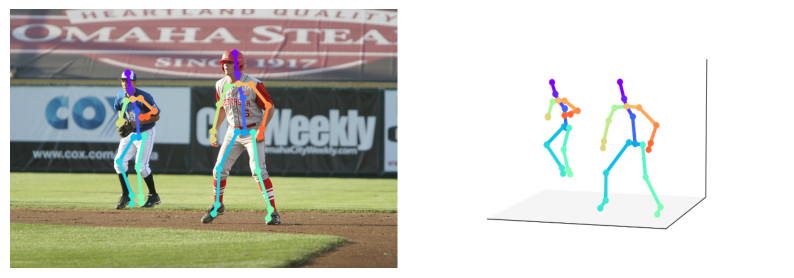

In [ ]:
# --- Colab test ---
if __name__ == '__main__':
    img_path = "datasets/coco_5k/valimages/000000132931.jpg"
    #img_path = "/content/gdrive/MyDrive/Hugging Face/datasets/excavators/Male-Posingsmall.jpg"
    image = cv2.imread(img_path)

    boxes, scores = detect_people(image)

    if boxes is None or len(boxes)==0:
        print("No person detected")
        sys.exit()

    # Simulate depth based on the bouding box area
    areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    depths = 500/(areas/(image.shape[0]*image.shape[1]))+500
    #depths = np.full(len(boxes), 1500)  # dummy depth

    pose_model_path = "mit-onnx-models/mobile_human_pose_working_well_256x256.onnx"
    pose_estimator = MobileHumanPose(pose_model_path)

    pose_img = image.copy()
    heatmap_viz_img = image.copy()
    img_heatmap = np.zeros(image.shape[:2], dtype=np.float32)
    pose_3d_list = []

    for i, bbox in enumerate(boxes):
        keypoints, pose_3d, person_heatmap, scores_k = pose_estimator(image, bbox, depths[i])
        pose_img = draw_skeleton(pose_img, keypoints, bbox[:2], scores_k)
        img_heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2]] += person_heatmap
        pose_3d_list.append(pose_3d)

    heatmap_viz_img = draw_heatmap(heatmap_viz_img, img_heatmap)
    vis_kps = np.array(pose_3d_list)
    img_3dpos = vis_3d_multiple_skeleton(vis_kps, np.ones_like(vis_kps))
    img_3dpos = cv2.resize(img_3dpos[200:-200,150:-150], image.shape[1::-1])
    combined_img = np.hstack((pose_img, img_3dpos))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

[[269  44 538 369]
 [  0 159 184 381]
 [175   0 277  68]
 [438  54 597 302]
 [135  66 272 305]
 [534  33 624 275]]


<Figure size 640x480 with 0 Axes>

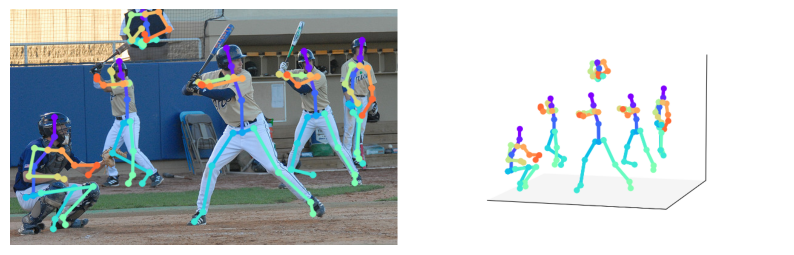

In [ ]:
if __name__ == '__main__':
    img_path = "datasets/coco_5k/valimages/000000160864.jpg"
    image = cv2.imread(img_path)

    boxes, scores = detect_people(image)

    if boxes is None or len(boxes)==0:
        print("No person detected")
        sys.exit()

    # Simulate depth based on the bouding box area
    areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    depths = 500/(areas/(image.shape[0]*image.shape[1]))+500
    #depths = np.full(len(boxes), 1500)  # dummy depth

    pose_model_path = "mit-onnx-models/mobile_human_pose_working_well_256x256.onnx"
    pose_estimator = MobileHumanPose(pose_model_path)

    pose_img = image.copy()
    heatmap_viz_img = image.copy()
    img_heatmap = np.zeros(image.shape[:2], dtype=np.float32)
    pose_3d_list = []

    for i, bbox in enumerate(boxes):
        keypoints, pose_3d, person_heatmap, scores_k = pose_estimator(image, bbox, depths[i])
        pose_img = draw_skeleton(pose_img, keypoints, bbox[:2], scores_k)
        img_heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2]] += person_heatmap
        pose_3d_list.append(pose_3d)

    heatmap_viz_img = draw_heatmap(heatmap_viz_img, img_heatmap)
    vis_kps = np.array(pose_3d_list)
    img_3dpos = vis_3d_multiple_skeleton(vis_kps, np.ones_like(vis_kps))
    img_3dpos = cv2.resize(img_3dpos[200:-200,150:-150], image.shape[1::-1])
    combined_img = np.hstack((pose_img, img_3dpos))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

[[246  87 431 468]
 [108  72 235 344]]


<Figure size 640x480 with 0 Axes>

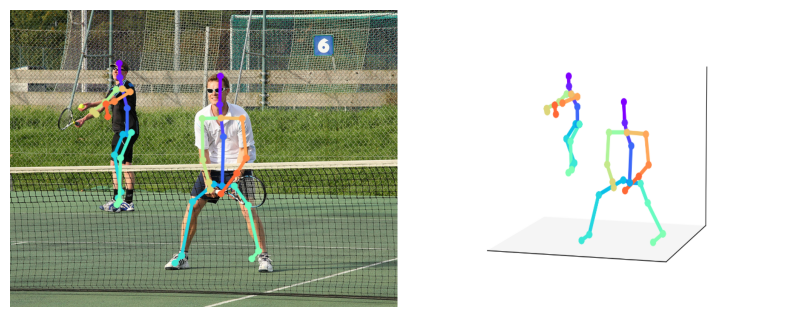

In [ ]:
if __name__ == '__main__':
    img_path = "datasets/coco_5k/valimages/000000203864.jpg"
    image = cv2.imread(img_path)

    boxes, scores = detect_people(image)

    if boxes is None or len(boxes)==0:
        print("No person detected")
        sys.exit()

    # Simulate depth based on the bouding box area
    areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    depths = 500/(areas/(image.shape[0]*image.shape[1]))+500
    #depths = np.full(len(boxes), 1500)  # dummy depth

    pose_model_path = "mit-onnx-models/mobile_human_pose_working_well_256x256.onnx"
    pose_estimator = MobileHumanPose(pose_model_path)

    pose_img = image.copy()
    heatmap_viz_img = image.copy()
    img_heatmap = np.zeros(image.shape[:2], dtype=np.float32)
    pose_3d_list = []

    for i, bbox in enumerate(boxes):
        keypoints, pose_3d, person_heatmap, scores_k = pose_estimator(image, bbox, depths[i])
        pose_img = draw_skeleton(pose_img, keypoints, bbox[:2], scores_k)
        img_heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2]] += person_heatmap
        pose_3d_list.append(pose_3d)

    heatmap_viz_img = draw_heatmap(heatmap_viz_img, img_heatmap)
    vis_kps = np.array(pose_3d_list)
    img_3dpos = vis_3d_multiple_skeleton(vis_kps, np.ones_like(vis_kps))
    img_3dpos = cv2.resize(img_3dpos[200:-200,150:-150], image.shape[1::-1])
    combined_img = np.hstack((pose_img, img_3dpos))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

[[175 147 426 460]
 [419  96 574 255]
 [ 96  68 263 402]
 [442  72 478 151]
 [261 151 349 230]]


<Figure size 640x480 with 0 Axes>

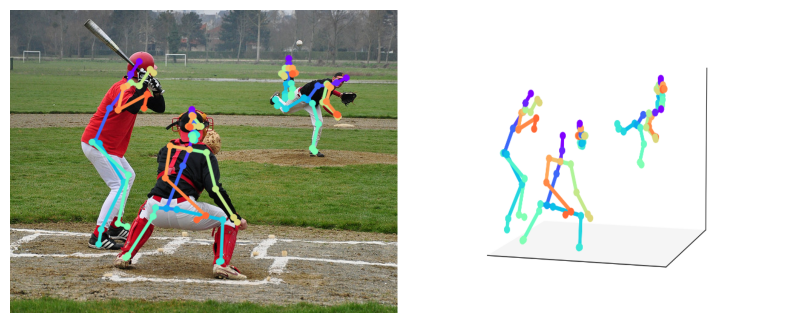

In [ ]:
if __name__ == '__main__':
    img_path = "datasets/coco_5k/images/000000342401.jpg"
    image = cv2.imread(img_path)

    boxes, scores = detect_people(image)

    if boxes is None or len(boxes)==0:
        print("No person detected")
        sys.exit()

    # Simulate depth based on the bouding box area
    areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    depths = 500/(areas/(image.shape[0]*image.shape[1]))+500
    #depths = np.full(len(boxes), 1500)  # dummy depth

    pose_model_path = "mit-onnx-models/mobile_human_pose_working_well_256x256.onnx"
    pose_estimator = MobileHumanPose(pose_model_path)

    pose_img = image.copy()
    heatmap_viz_img = image.copy()
    img_heatmap = np.zeros(image.shape[:2], dtype=np.float32)
    pose_3d_list = []

    for i, bbox in enumerate(boxes):
        keypoints, pose_3d, person_heatmap, scores_k = pose_estimator(image, bbox, depths[i])
        pose_img = draw_skeleton(pose_img, keypoints, bbox[:2], scores_k)
        img_heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2]] += person_heatmap
        pose_3d_list.append(pose_3d)

    heatmap_viz_img = draw_heatmap(heatmap_viz_img, img_heatmap)
    vis_kps = np.array(pose_3d_list)
    img_3dpos = vis_3d_multiple_skeleton(vis_kps, np.ones_like(vis_kps))
    img_3dpos = cv2.resize(img_3dpos[200:-200,150:-150], image.shape[1::-1])
    combined_img = np.hstack((pose_img, img_3dpos))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

[[175 114 320 427]
 [298 147 427 420]]


<Figure size 640x480 with 0 Axes>

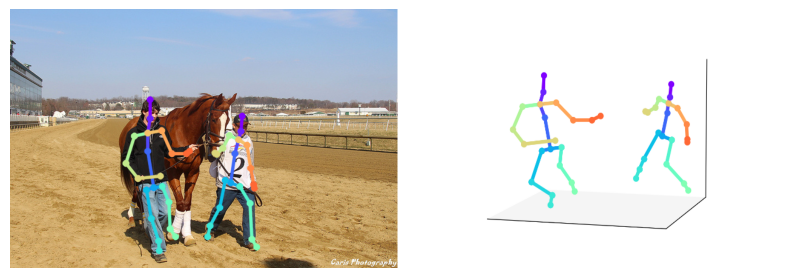

In [ ]:
if __name__ == '__main__':
    img_path = "datasets/coco_5k/images/000000483156.jpg"
    image = cv2.imread(img_path)

    boxes, scores = detect_people(image)

    if boxes is None or len(boxes)==0:
        print("No person detected")
        sys.exit()

    # Simulate depth based on the bouding box area
    areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    depths = 500/(areas/(image.shape[0]*image.shape[1]))+500
    #depths = np.full(len(boxes), 1500)  # dummy depth

    pose_model_path = "mit-onnx-models/mobile_human_pose_working_well_256x256.onnx"
    pose_estimator = MobileHumanPose(pose_model_path)

    pose_img = image.copy()
    heatmap_viz_img = image.copy()
    img_heatmap = np.zeros(image.shape[:2], dtype=np.float32)
    pose_3d_list = []

    for i, bbox in enumerate(boxes):
        keypoints, pose_3d, person_heatmap, scores_k = pose_estimator(image, bbox, depths[i])
        pose_img = draw_skeleton(pose_img, keypoints, bbox[:2], scores_k)
        img_heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2]] += person_heatmap
        pose_3d_list.append(pose_3d)

    heatmap_viz_img = draw_heatmap(heatmap_viz_img, img_heatmap)
    vis_kps = np.array(pose_3d_list)
    img_3dpos = vis_3d_multiple_skeleton(vis_kps, np.ones_like(vis_kps))
    img_3dpos = cv2.resize(img_3dpos[200:-200,150:-150], image.shape[1::-1])
    combined_img = np.hstack((pose_img, img_3dpos))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()